In [1]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.5)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# pra for precision recall accuracy - for displaying information for these metrics quickly
def pra(y_true, y_pred):
    p, r, f, s = score(y_true, y_pred)
    print("Precision: {} +/- {}\nRecall: {} +/- {}\nAccuracy: {}%"
          .format(round(np.mean(p), 3), round(np.std(p), 3), round(np.mean(r), 3), round(np.std(r), 3), 
                  100*np.round((y_pred==y_true).sum()/len(y_true), 3)))

In [3]:
# Read csv into dataframe
df = pd.read_csv('Data/210907_Essay_score_cleaned_2.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     2600 non-null   int64  
 1   Code           2600 non-null   object 
 2   Country        2600 non-null   object 
 3   PTJ1           2600 non-null   int64  
 4   SMK1           2600 non-null   int64  
 5   Sex            2600 non-null   object 
 6   Age            2600 non-null   int64  
 7   Grade          2474 non-null   float64
 8   Major          2496 non-null   object 
 9   Field          2496 non-null   object 
 10  VST            2600 non-null   float64
 11  CEFR           2600 non-null   object 
 12  INTM           2600 non-null   float64
 13  INSM           2600 non-null   float64
 14  Primary        2600 non-null   float64
 15  Secondary      2600 non-null   float64
 16  College        2600 non-null   float64
 17  Inschool       2600 non-null   float64
 18  Outschoo

In [5]:
# N/A's import as isna's. deal with them, and also reconvert Grade to type string.
cols = ['Grade', 'Major', 'Field']
for c in cols:
    df[c] = df[c].fillna('N/A')
df.Grade = df.Grade.astype(str)
df = df.drop(['Unnamed: 0', 'Code'], axis=1)

In [6]:
# Define X and y - target variable is Country. All else keep in X.
X = df.drop(['Country'], axis=1).copy()
y = df.Country.copy()

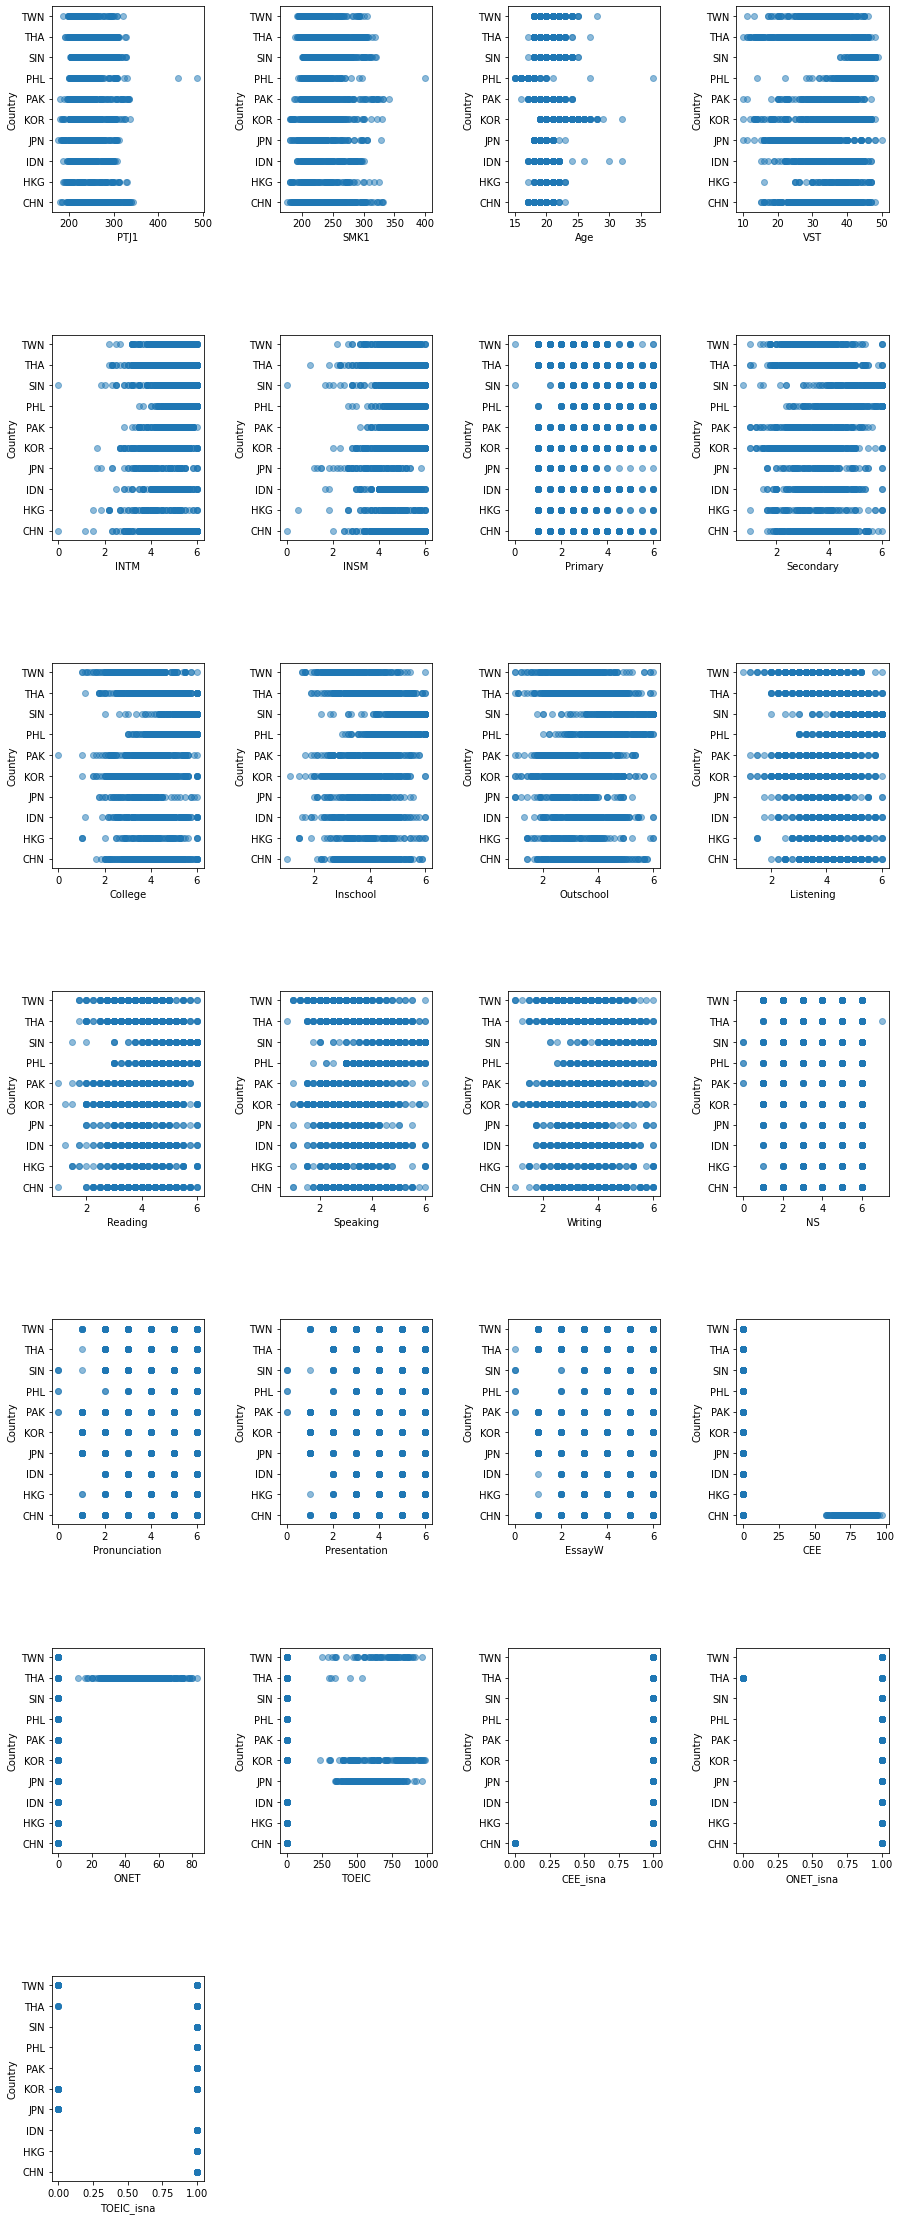

In [7]:
# Quick EDA numeric variables to target variable to visualize any quick patterns.
scatterplots(columns = X.select_dtypes(include=np.number).columns, y_col = 'Country', data=df, ncol=4, figsize=(15,40))

In [8]:
# Get dummies for categorical variables.
X = pd.get_dummies(X, dtype='int64')

In [9]:
# Train test split on X and y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print shape and types of outputs.
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(1950, 181) (650, 181) (1950,) (650,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [46]:
# Random Forest Classifier - initiate.
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Parameters for grid search.
params = {
    'n_estimators': [int(n) for n in np.logspace(1,3,5)],
    'max_depth': [None, 10, 20, 30]
}

# Grid search with 5-fold CV. Fit, and display best parameters, then details on top five CV performers.
rf_grid_cv = GridSearchCV(rf, params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'max_depth': 30, 'n_estimators': 316}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,2.369065,0.903563,0.153785,0.047257,30,316,"{'max_depth': 30, 'n_estimators': 316}",0.884615,0.823077,0.864103,0.879487,0.846154,0.859487,0.022611,1
19,3.911483,0.209199,0.730245,0.091394,30,1000,"{'max_depth': 30, 'n_estimators': 1000}",0.879487,0.838462,0.856410,0.874359,0.846154,0.858974,0.015806,2
4,4.022435,0.177684,0.606576,0.126804,None,1000,"{'max_depth': None, 'n_estimators': 1000}",0.882051,0.838462,0.853846,0.871795,0.848718,0.858974,0.015806,2
3,1.165880,0.073240,0.131049,0.020610,None,316,"{'max_depth': None, 'n_estimators': 316}",0.879487,0.828205,0.856410,0.876923,0.848718,0.857949,0.018954,4
13,2.078040,0.530563,0.115688,0.015046,20,316,"{'max_depth': 20, 'n_estimators': 316}",0.879487,0.833333,0.853846,0.864103,0.846154,0.855385,0.015689,5


In [49]:
# Picking 'second best' RF classifier in this case. 
# Mean score was essentially a tie but Std score was better. Store as rf_best.
rf_best=RandomForestClassifier(max_depth=30, n_estimators=1000, random_state=42, n_jobs=-1)
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

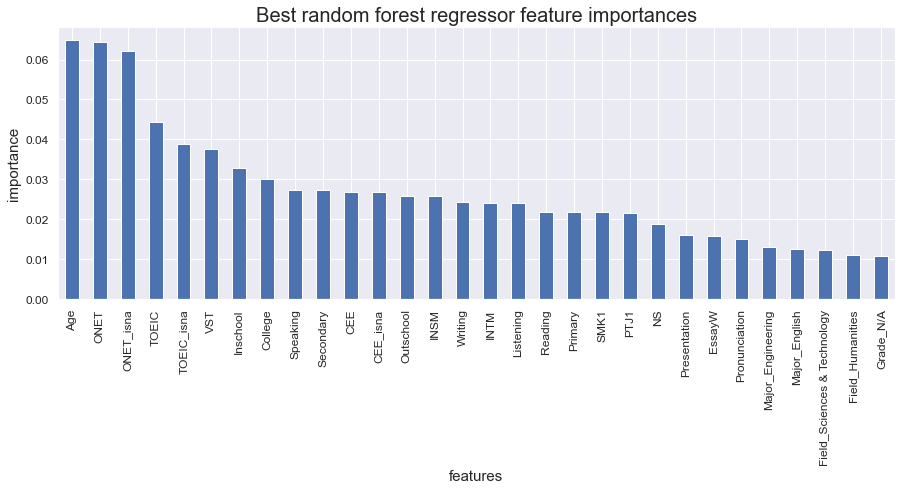

In [57]:
# Train rf_best on training data.
rf_best.fit(X_train, y_train)

# Plot the 30 most important features to best fit model.
plt.subplots(figsize=(15, 5))
imps = rf_best.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[:30]
rf_feat_imps.plot(kind='bar', fontsize=12)
plt.xlabel('features', fontsize=15)
plt.ylabel('importance', fontsize=15)
plt.title('Best random forest regressor feature importances', fontsize=20);

In [88]:
# Predict on Training set and Test set.
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)

# Print metrics for training and testing.
pra(y_train, y_tr_rf_pred)
pra(y_test, y_te_rf_pred)

Precision: 1.0 +/- 0.0
Recall: 1.0 +/- 0.0
Accuracy: 100.0%
Precision: 0.854 +/- 0.099
Recall: 0.828 +/- 0.173
Accuracy: 87.1%


In [91]:
# Initialize XG Boost model - objective Decision Tree.
xg = XGBClassifier(objective='reg:linear', seed=42)

# Grid Search parameters
params = {
    'max_depth': range(1, 4),
    'n_estimators': [int(n) for n in np.logspace(2,3,3)],
    'learning_rate': [n for n in np.logspace(-3,0,4)]
}

# Grid search with 5-fold CV. Fit, and display best parameters, then details on top five CV performers.
xg_grid_cv = GridSearchCV(xg, params, cv=5, n_jobs=-1)
xg_grid_cv.fit(X_train, y_train)
print(xg_grid_cv.best_params_)
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

C:\Users\jaeyo\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 316}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,34.157122,0.279490,0.013378,0.001030,0.1,3,316,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.884615,0.841026,0.889744,0.894872,0.884615,0.878974,0.019352,1
20,48.403560,0.751007,0.015958,0.002185,0.1,1,1000,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.887179,0.858974,0.876923,0.882051,0.882051,0.877436,0.009784,2
22,25.084121,0.385351,0.011770,0.001323,0.1,2,316,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.887179,0.848718,0.879487,0.882051,0.882051,0.875897,0.013818,3
23,75.129094,0.389891,0.021541,0.003547,0.1,2,1000,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.884615,0.848718,0.882051,0.879487,0.876923,0.874359,0.013074,4
26,96.237802,1.005842,0.027428,0.007828,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.887179,0.830769,0.879487,0.884615,0.884615,0.873333,0.021428,5


In [100]:
# Store best estimator to xg_best. Fit xg_best on training set.
xg_best = xg_grid_cv.best_estimator_
xg_best.fit(X_train, y_train)

[08:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=316, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

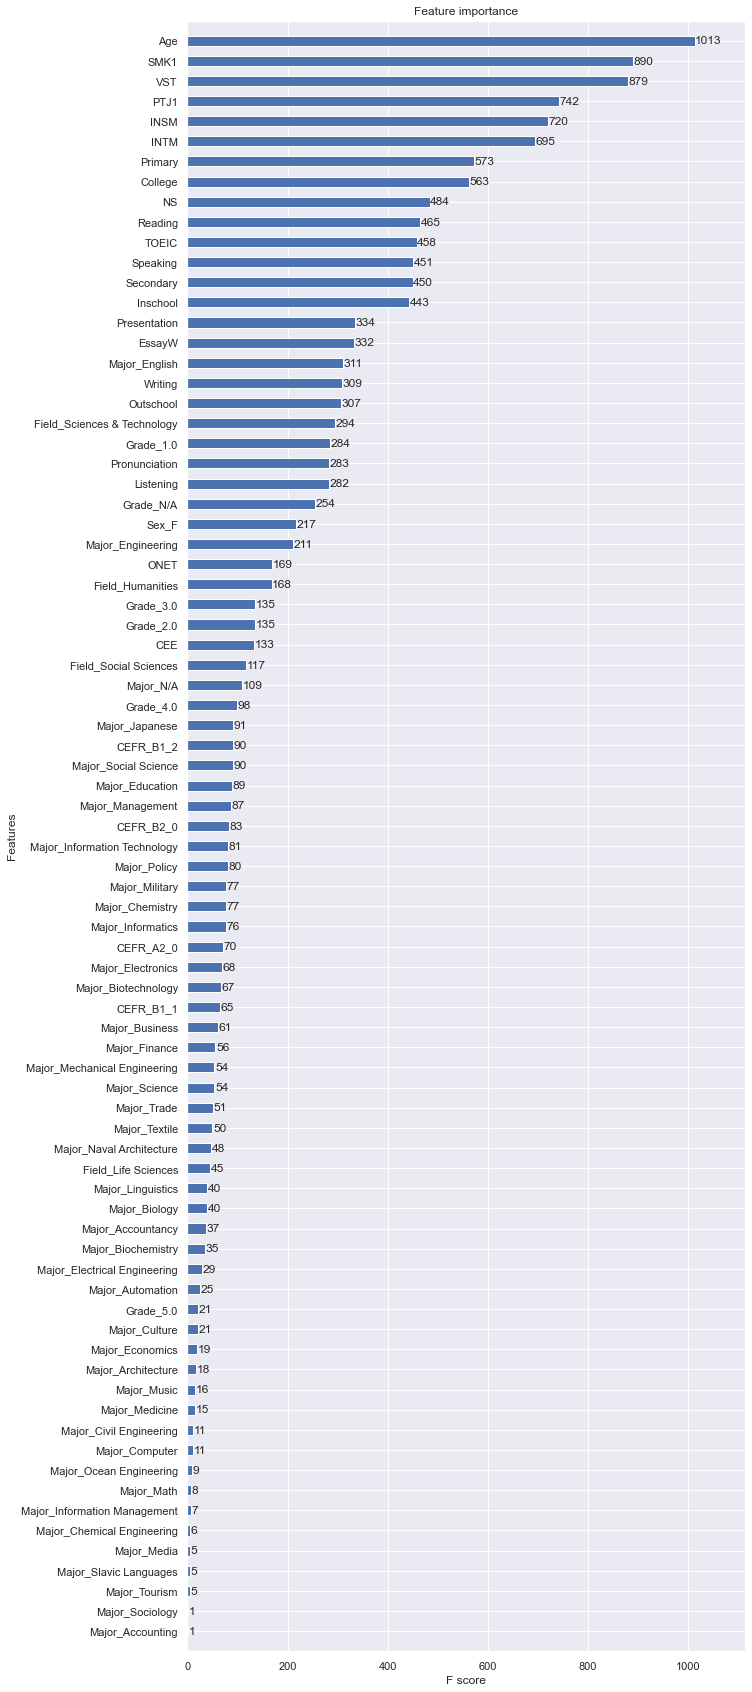

In [101]:
# Plot feature importances of xg_best.
fig, ax = plt.subplots(figsize=(10,30))
xgb.plot_importance(xg_best, ax=ax, height=0.5)
plt.show()

In [102]:
# Predict on training and test sets.
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)

# Print metrics.
pra(y_train, y_tr_xg_pred)
pra(y_test, y_te_xg_pred)

Precision: 1.0 +/- 0.0
Recall: 1.0 +/- 0.0
Accuracy: 100.0%
Precision: 0.885 +/- 0.089
Recall: 0.868 +/- 0.107
Accuracy: 89.8%
